# 1. Summary of Mark Minervini Strategy

| Condition No. | Description                                      | Code Snippet                                                                      |
|---------------|--------------------------------------------------|-----------------------------------------------------------------------------------|
| 1             | Price > 150-day SMA and price > 200-day SMA      | `if not (self.price > self.sma150 and self.price > self.sma200): return False`    |
| 2             | 150-day SMA > 200-day SMA                        | `if not (self.sma150 > self.sma200): return False`                                |
| 3             | 200-day SMA rising vs 20 days ago                | `if not (self.sma200 > float(sma200_vals.iloc[-21])): return False`               |
| 4             | 50-day SMA > 150-day SMA > 200-day SMA stack     | `if not (self.sma50 > self.sma150 and self.sma150 > self.sma200): return False`   |
| 5             | Price > 50-day SMA                               | `if not (self.price > self.sma50): return False`                                  |
| 6             | Price ≥ 1.3 × 52-week low                        | `if not (self.price >= 1.3 * self.low52): return False`                           |
| 7             | Price ≥ 0.75 × 52-week high                      | `if not (self.price >= 0.75 * self.high52): return False`                         |
| 8             | RS rating ≥ min_rs threshold                     | `if not (self.rs_rating >= self.min_rs): return False`                            |


Running Minervini screener...
Screening 7 stocks: AAPL, MSFT, GOOGL, AMZN, NVDA, TSLA, META
--------------------------------------------------
Successfully fetched SPY benchmark data. RS: 1.1066
Processing AAPL...
  AAPL: Failed trend template conditions
Processing MSFT...
  MSFT: PASSED all conditions!
Processing GOOGL...
  GOOGL: Failed trend template conditions
Processing AMZN...
  AMZN: Failed trend template conditions
Processing NVDA...
  NVDA: Failed trend template conditions
Processing TSLA...
  TSLA: Failed trend template conditions
Processing META...
  META: Failed trend template conditions
--------------------------------------------------

1 stocks passed the screener:
Ticker  Price  RS Rating  SMA50  SMA150  SMA200  52w Low  52w High
  MSFT 474.96       95.4  425.3  418.15  418.12   353.91    478.87

Generating charts...


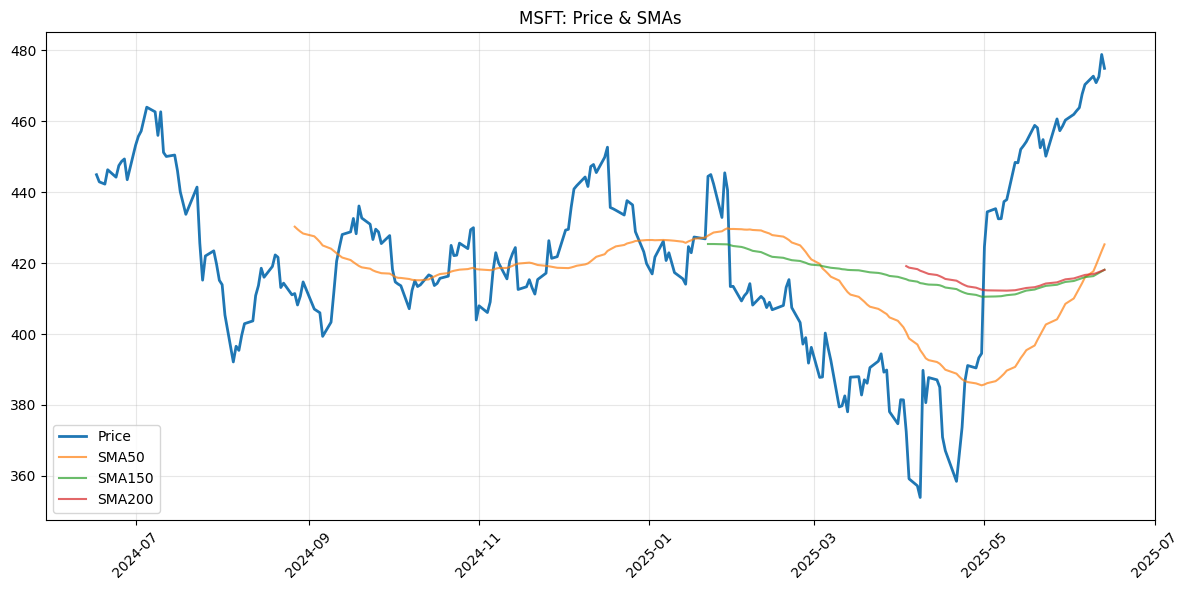

In [15]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------------------------
PRICE_COL = "Adj Close"  # column to reference for price data

# ---------------------------------------------------------------------------
# UTILITIES
# ---------------------------------------------------------------------------

def fetch_hist(symbol: str, days: int = 365) -> pd.DataFrame:
    """Download daily OHLCV data for the given symbol over the past days via yfinance."""
    start_date = datetime.date.today() - datetime.timedelta(days=days)
    raw = yf.download(symbol, start=start_date, progress=False)

    # Fix: Use len() instead of .empty for MultiIndex DataFrames
    if len(raw) == 0:
        raise ValueError(f"No data for symbol {symbol}")

    # Handle MultiIndex columns if present
    if isinstance(raw.columns, pd.MultiIndex):
        # Flatten MultiIndex columns - take the first level
        raw.columns = raw.columns.droplevel(1)

    # ensure price column
    if PRICE_COL not in raw.columns:
        if "Close" in raw.columns:
            raw = raw.rename(columns={"Close": PRICE_COL})
        else:
            raise KeyError(f"No '{PRICE_COL}' or 'Close' column in data for {symbol}")

    # Ensure we have the required columns
    required_cols = [PRICE_COL, 'Volume']
    available_cols = [col for col in required_cols if col in raw.columns]

    if len(available_cols) < 2:
        raise KeyError(f"Missing required columns for {symbol}. Available: {list(raw.columns)}")

    return raw[available_cols].dropna().copy()


def calc_relative_strength(df: pd.DataFrame, price_col: str = PRICE_COL) -> float:
    """Compute simple RS: average gain divided by average loss."""
    if len(df) == 0 or price_col not in df.columns:
        return np.nan

    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if avg_loss == 0 or pd.isna(avg_loss) or avg_loss is None:
        return np.nan
    return avg_gain / avg_loss

# ---------------------------------------------------------------------------
# TREND TEMPLATE CLASS
# ---------------------------------------------------------------------------

class TrendTemplate:
    """Apply Mark Minervini's 8 conditions to a stock."""

    def __init__(self, symbol: str, df: pd.DataFrame, benchmark_rs: float, min_rs: int = 70):
        self.symbol = symbol
        self.df = df.tail(300).copy()

        # Ensure we have enough data
        if len(self.df) < 200:
            raise ValueError(f"Insufficient data for {symbol}: {len(self.df)} days")

        # compute SMAs
        for w in (50, 150, 200):
            self.df[f"SMA{w}"] = self.df[PRICE_COL].rolling(w).mean()

        # latest metrics - use more robust extraction
        try:
            self.price = float(self.df[PRICE_COL].iloc[-1])
            self.sma50 = float(self.df["SMA50"].iloc[-1])
            self.sma150 = float(self.df["SMA150"].iloc[-1])
            self.sma200 = float(self.df["SMA200"].iloc[-1])
        except (IndexError, ValueError, TypeError) as e:
            raise ValueError(f"Error extracting metrics for {symbol}: {e}")

        # 52-week extremes
        year_window = self.df.tail(min(260, len(self.df)))
        self.low52 = float(year_window[PRICE_COL].min())
        self.high52 = float(year_window[PRICE_COL].max())

        # relative strength
        stock_rs = calc_relative_strength(self.df)

        # Fix: Handle NaN benchmark_rs more safely
        if pd.isna(benchmark_rs) or benchmark_rs == 0 or benchmark_rs is None:
            self.rs_rating = 0
        elif pd.isna(stock_rs) or stock_rs is None:
            self.rs_rating = 0
        else:
            self.rs_rating = 100 * stock_rs / benchmark_rs

        self.min_rs = min_rs

    def passes(self) -> bool:
        """Return True if all eight Trend Template conditions are met."""
        # Fix: Add explicit checks for NaN values
        if any(pd.isna(x) for x in [self.price, self.sma50, self.sma150, self.sma200]):
            return False

        # Cond1: price > SMA150 and price > SMA200
        if not (self.price > self.sma150 and self.price > self.sma200):
            return False
        # Cond2: SMA150 > SMA200
        if not (self.sma150 > self.sma200):
            return False
        # Cond3: SMA200 rising vs 20 days ago
        sma200_vals = self.df["SMA200"].dropna()
        if len(sma200_vals) >= 21:
            try:
                sma200_20_days_ago = float(sma200_vals.iloc[-21])
                if pd.isna(sma200_20_days_ago) or not (self.sma200 > sma200_20_days_ago):
                    return False
            except (IndexError, ValueError):
                return False
        else:
            return False
        # Cond4: SMA50 > SMA150 > SMA200
        if not (self.sma50 > self.sma150 and self.sma150 > self.sma200):
            return False
        # Cond5: price > SMA50
        if not (self.price > self.sma50):
            return False
        # Cond6: price >= 1.3 * 52-week low
        if pd.isna(self.low52) or not (self.price >= 1.3 * self.low52):
            return False
        # Cond7: price >= 0.75 * 52-week high
        if pd.isna(self.high52) or not (self.price >= 0.75 * self.high52):
            return False
        # Cond8: RS rating >= min_rs
        if pd.isna(self.rs_rating) or not (self.rs_rating >= self.min_rs):
            return False
        return True

    def summary(self) -> dict:
        """Return a dict summary of key metrics."""
        return {
            "Ticker": self.symbol,
            "Price": round(self.price, 2),
            "RS Rating": round(self.rs_rating, 1) if not pd.isna(self.rs_rating) else 0,
            "SMA50": round(self.sma50, 2),
            "SMA150": round(self.sma150, 2),
            "SMA200": round(self.sma200, 2),
            "52w Low": round(self.low52, 2),
            "52w High": round(self.high52, 2),
        }

# ---------------------------------------------------------------------------
# SCREENER & PLOTTING
# ---------------------------------------------------------------------------

def screen(tickers: list, days: int = 365, min_vol: float = 1e6, min_price: float = 0, min_rs: int = 70) -> pd.DataFrame:
    """Return DataFrame of tickers passing the Trend Template."""
    # benchmark RS using SPY
    try:
        spy_df = fetch_hist("SPY", days)
        benchmark_rs = calc_relative_strength(spy_df)
        print(f"Successfully fetched SPY benchmark data. RS: {benchmark_rs:.4f}")
    except Exception as e:
        print(f"Warning: Could not fetch SPY data for benchmark: {e}")
        benchmark_rs = 1.0  # Default fallback

    results = []
    for sym in tickers:
        try:
            print(f"Processing {sym}...")
            df = fetch_hist(sym, days)
        except Exception as e:
            print(f"Skipping {sym}: {e}")
            continue

        # basic filters
        try:
            avg_volume = df['Volume'].mean() if 'Volume' in df.columns and len(df) > 0 else 0
            if avg_volume < min_vol:
                print(f"  {sym}: Volume too low ({avg_volume:,.0f} < {min_vol:,.0f})")
                continue

            latest_price = float(df[PRICE_COL].iloc[-1]) if len(df) > 0 else 0
            if latest_price < min_price:
                print(f"  {sym}: Price too low (${latest_price:.2f} < ${min_price:.2f})")
                continue

            tt = TrendTemplate(sym, df, benchmark_rs, min_rs)
            if tt.passes():
                print(f"  {sym}: PASSED all conditions!")
                results.append(tt.summary())
            else:
                print(f"  {sym}: Failed trend template conditions")

        except Exception as e:
            print(f"  {sym}: Error in analysis: {e}")
            continue

    return pd.DataFrame(results)


def plot_symbol(symbol: str, days: int = 365):
    """Plot price with SMAs for a given symbol."""
    try:
        df = fetch_hist(symbol, days)
        for w in (50, 150, 200):
            df[f"SMA{w}"] = df[PRICE_COL].rolling(w).mean()

        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df[PRICE_COL], label='Price', linewidth=2)
        plt.plot(df.index, df['SMA50'], label='SMA50', alpha=0.7)
        plt.plot(df.index, df['SMA150'], label='SMA150', alpha=0.7)
        plt.plot(df.index, df['SMA200'], label='SMA200', alpha=0.7)
        plt.title(f"{symbol}: Price & SMAs")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting {symbol}: {e}")

# ---------------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------------

def main():
    universe = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "META"]
    print("Running Minervini screener...")
    print(f"Screening {len(universe)} stocks: {', '.join(universe)}")
    print("-" * 50)

    df_pass = screen(universe, days=365, min_vol=5e6, min_price=10, min_rs=70)

    print("-" * 50)
    # Fix: Use len() instead of shape[0] for clearer logic
    if len(df_pass) == 0:
        print("No stocks passed the Minervini screener.")
    else:
        print(f"\n{len(df_pass)} stocks passed the screener:")
        print(df_pass.to_string(index=False))
        print("\nGenerating charts...")
        # Fix: Convert to list to avoid any Series iteration issues
        passing_tickers = df_pass['Ticker'].tolist()
        for sym in passing_tickers:
            plot_symbol(sym)

if __name__ == "__main__":
    main()

# Entry and Exit Price Targets


## 2. Entry Definition (per *Think & Trade Like a Champion*)

1. **Pivot-Point Breakout**  
   Buy when the stock “breaks upward out of its most recent contraction” (clears last 3-bar pivot high) on strong volume .

2. **1% Above Pivot**  
   Wait for a close ≥ 1 % above that pivot high to avoid false breakouts .

3. **Volume Surge**  
   Confirm with volume ≥ 50-day average (ideally +20–50 %) .

4. **Optional VCP Entry**  
   In a Volatility Contraction Pattern, enter on the first close above the last contraction’s high on heavy volume .

In [18]:
# ─── ENTRY CODE ──────────────────────────────────────────────────────────────
import pandas as pd
import yfinance as yf

symbol    = 'MSFT'
price_col = 'Adj Close'

# 1. Get one year of OHLCV
df = yf.download(symbol, period='1y', progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
if price_col not in df.columns:
    df.rename(columns={'Close': price_col}, inplace=True)
df = df[['High', price_col, 'Volume']].dropna()

# 2. Locate the last 3-bar pivot high
h = df['High']
pivot_high = (
    (h > h.shift(1)) &
    (h > h.shift(2)) &
    (h > h.shift(-1)) &
    (h > h.shift(-2))
)
last_ph_date  = h[pivot_high].index[-1]
last_ph_price = float(h[pivot_high].iloc[-1])

# 3. Entry = 1% above that pivot high
entry_price = last_ph_price * 1.01

print(f"Last pivot high: {last_ph_date.date()} at ${last_ph_price:.2f}")
print(f"Entry trigger (1% above): ${entry_price:.2f}")


Last pivot high: 2025-05-28 at $462.52
Entry trigger (1% above): $467.15



## 3. Exit Definition

1. **Initial Stop-Loss:**  
   Place a stop at the last three-bar pivot low (low of the bar below both neighbors) .

2. **Move to Breakeven:**  
   After a gain ≈ 2× initial risk, shift stop to entry to eliminate risk .

3. **50-Day SMA Breach:**  
   Exit remaining shares on a close below the 50-day SMA on volume spike .

4. **Partial Profit-Taking:**  
   Trim 25–50 % of position at 20–30 % gains and tighten stops on the rest .

5. **Final Pivot-Low Undercut:**  
   Sell any leftovers if price undercuts the prior pivot low on increased volume .

In [19]:
# ─── EXIT CODE ────────────────────────────────────────────────────────────────
import pandas as pd
import yfinance as yf

symbol    = 'MSFT'
price_col = 'Adj Close'

# 1. Re-fetch the same OHLCV
df = yf.download(symbol, period='1y', progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
if price_col not in df.columns:
    df.rename(columns={'Close': price_col}, inplace=True)
df = df[['Low', price_col, 'Volume']].dropna()

# 2. Protective stop at last 3-bar pivot low
l = df['Low']
pivot_low = (
    (l < l.shift(1)) &
    (l < l.shift(2)) &
    (l < l.shift(-1)) &
    (l < l.shift(-2))
)
last_pl_date  = l[pivot_low].index[-1]
last_pl_price = float(l[pivot_low].iloc[-1])
stop_price    = last_pl_price

# 3. Alternate exit: breach of 50-day SMA on volume spike
sma50     = df[price_col].rolling(50).mean().iloc[-1]
vol50_avg = df['Volume'].rolling(50).mean().iloc[-1]

print(f"Last pivot low:   {last_pl_date.date()} at ${last_pl_price:.2f}")
print(f"Stop-loss level:  ${stop_price:.2f}")
print(f"Exit if close < 50-SMA (${sma50:.2f}) on vol ≥ {vol50_avg:.0f}")


Last pivot low:   2025-06-10 at $466.96
Stop-loss level:  $466.96
Exit if close < 50-SMA ($425.30) on vol ≥ 23401614


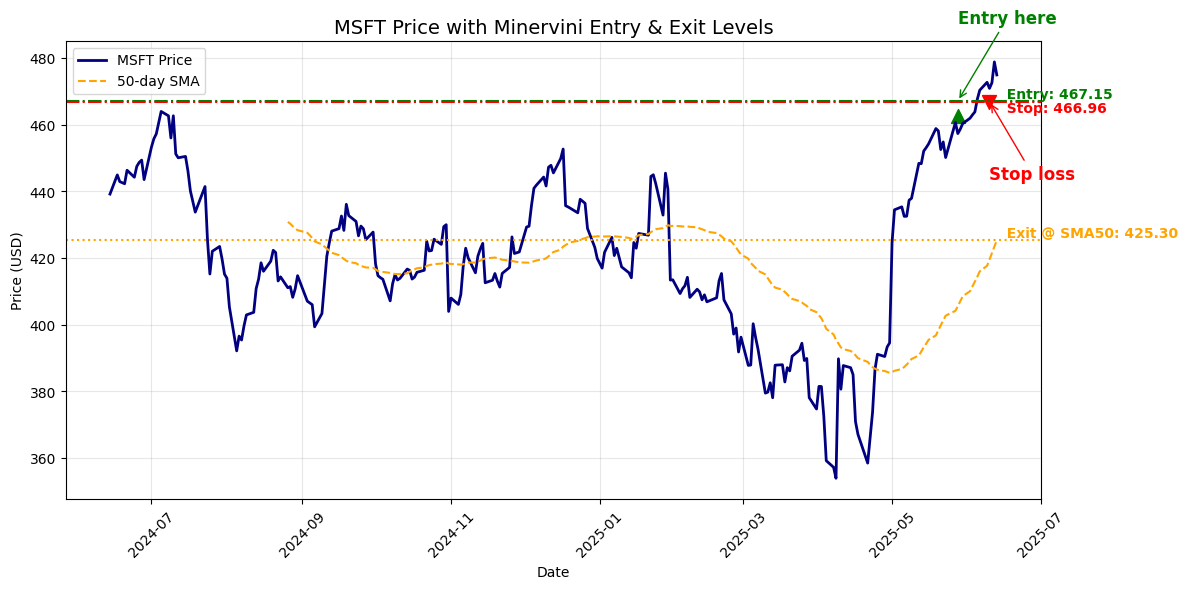

In [21]:
# ─── ENTRY & EXIT ANNOTATED VISUALIZATION ────────────────────────────────────
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

symbol    = 'MSFT'
price_col = 'Adj Close'

# Fetch one year of data
df = yf.download(symbol, period='1y', progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
if price_col not in df.columns:
    df.rename(columns={'Close': price_col}, inplace=True)
df = df[[price_col, 'High', 'Low', 'Volume']].dropna()

# Compute pivot high (entry) and pivot low (stop)
h = df['High']
pivot_high_mask = (
    (h > h.shift(1)) & (h > h.shift(2)) &
    (h > h.shift(-1)) & (h > h.shift(-2))
)
ph_date  = pivot_high_mask[pivot_high_mask].index[-1]
ph_price = float(h[pivot_high_mask].iloc[-1])
entry_price = ph_price * 1.01

l = df['Low']
pivot_low_mask = (
    (l < l.shift(1)) & (l < l.shift(2)) &
    (l < l.shift(-1)) & (l < l.shift(-2))
)
pl_date  = pivot_low_mask[pivot_low_mask].index[-1]
pl_price = float(l[pivot_low_mask].iloc[-1])
stop_price = pl_price

# 50-day SMA (exit)
sma50 = df[price_col].rolling(50).mean().iloc[-1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[price_col], label='MSFT Price', color='navy', linewidth=2)
plt.plot(df.index, df[price_col].rolling(50).mean(), label='50-day SMA', linestyle='--', color='orange')

# Mark and annotate pivot high (Entry)
plt.scatter([ph_date], [ph_price], color='green', marker='^', s=100)
plt.annotate(
    'Entry here',
    xy=(ph_date, entry_price),
    xytext=(ph_date, entry_price * 1.05),
    arrowprops=dict(arrowstyle='->', color='green'),
    color='green', fontsize=12, fontweight='bold'
)

# Mark and annotate pivot low (Stop)
plt.scatter([pl_date], [pl_price], color='red', marker='v', s=100)
plt.annotate(
    'Stop loss',
    xy=(pl_date, stop_price),
    xytext=(pl_date, stop_price * 0.95),
    arrowprops=dict(arrowstyle='->', color='red'),
    color='red', fontsize=12, fontweight='bold'
)

# Draw and annotate entry and stop lines
plt.axhline(entry_price, color='green', linestyle='-.', linewidth=1.5)
plt.text(df.index[-1], entry_price, f'  Entry: {entry_price:.2f}', color='green', va='bottom', fontweight='bold')

plt.axhline(stop_price, color='red', linestyle='-.', linewidth=1.5)
plt.text(df.index[-1], stop_price, f'  Stop: {stop_price:.2f}', color='red', va='top', fontweight='bold')

# Annotate 50-day SMA exit level
plt.axhline(sma50, color='orange', linestyle=':', linewidth=1.5)
plt.text(df.index[-1], sma50, f'  Exit @ SMA50: {sma50:.2f}', color='orange', va='bottom', fontweight='bold')

plt.title('MSFT Price with Minervini Entry & Exit Levels', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
